<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/Final_Submission_LGB_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import gc
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re
import string
import tempfile
import warnings
import ast

import lightgbm as lgb
import xgboost as xgb

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix,r2_score, roc_curve, make_scorer,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

#from imblearn.over_sampling import SMOTE, SVMSMOTE
#from imblearn.under_sampling import RandomUnderSampler, TomekLinks
#from imblearn.combine import SMOTETomek
#from imblearn.pipeline import Pipeline

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval


################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],axis=0,ignore_index=True)

################### Load Spell Check ###################
# Load word2vec model pre-trained on Google News corpus (3 billion running words) 
"""
t0 = time.time()
google = api.load('word2vec-google-news-300')

words = google.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i
WORDS = w_rank

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

print("Time taken to load SpellChecker: {}m".format(round((time.time()-t0)/60,2)))
"""
################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Determine if file words exist:
#print(len(df[df['comment_text'].str.contains('jpg')]))
#print(len(df[df['comment_text'].str.contains('jpeg')]))
#print(len(df[df['comment_text'].str.contains('http')]))
#print(len(df[df['comment_text'].str.contains('pdf')]))
#print(len(df[df['comment_text'].str.contains('html')]))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc,use_stop=True):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', r' ', doc)
    # 4) Remove extra whitespaces
    doc = re.sub(r"\s+",r" ",doc)
    # 5) Remove leading/trailing whitespaces
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    if use_stop:
      # filter stopwords out of document
      filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
      filtered_tokens = tokens
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Old-school lemmatization
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc if token.lemma_ != '-PRON-']         

# Spell-check, then lemmatize
def spell_and_lemmatize(doc,lemmatize=True):
    # 1) Replace contraction patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 2) Remove special characters, replace newlines with spaces, remove extra spaces
    doc = re.sub(r'[^a-zA-Z\s]+', ' ', doc)
    doc = re.sub(r'[\n\r\t\r\n]',r' ',doc,re.I|re.U)
    doc = re.sub(r"\s+",r" ",doc)
    # 3) Remove leading and trailing whitespaces
    doc = doc.strip()
    # 4) Filter only verbs, nouns, adjectives, and adverbs. Remove stopwords.
    filtered = [token.text for token in spacy_nlp(doc) if token.pos_ in ['VERB','NOUN','ADJ','ADV','PROPN'] and token.text.lower() not in stop_words]
    # 5) Spell-check words that are not proper nouns
    corrected = [correction(token.text) if token.pos_ != 'PROPN' else token.text for token in spacy_nlp(" ".join(filtered))]
    if lemmatize == True:
      # 6) Apply lemmatization to spell-checked words
      lemmas = [token.lemma_ if token.pos_ != 'PROPN' else token.text for token in spacy_nlp(" ".join(corrected))]
      # 7) Remove pronouns, convert to lowercase
      final_lemmas = [token.text.lower() for token in spacy_nlp(" ".join(lemmas)) if token.lemma_ != '-PRON-']
      return final_lemmas
    else:
      return [text.lower() for text in corrected]

## Clean and lemmatize comments
#df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
#df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
#df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
#df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = [spell_and_lemmatize(x,lemmatize=True) for x in train['comment_text']]
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))
#train['clean_spelled'] = [spell_and_lemmatize(x,lemmatize=False) for x in train['comment_text']]
#train['clean_spelled_str'] = train['clean_spelled'].apply(lambda x: " ".join(x))

## Write to csv for download
#from google.colab import drive
#drive.mount('/content/drive')
#train['clean_comments'].to_csv('train_clean_comments.csv',sep=',',index=False)
#train['clean_lemmed_str'].to_csv('train_clean_lemmed.csv',sep=',',index=False)
#train['clean_spelled_str'].to_csv('train_clean_spelled.csv',sep=',',index=False)

## Read from csv
#train_clean_comments = pd.read_csv('train_clean_comments.csv',header=None)
#train_clean_lemmed = pd.read_csv('train_clean_lemmed.csv',header=None)
#train_clean_spelled = pd.read_csv('train_clean_spelled.csv',header=None)


## Transform cleaned/lemmed strings
#train['clean_comments'] = train_clean_comments[0].apply(lambda x: str(x))
#train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: str(x))
#train['clean_lemmed_list'] = train['clean_lemmed'].apply(lambda x: x.split())
#train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: ast.literal_eval(x))
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))
#train['clean_spelled'] = train_clean_spelled[0].apply(lambda x: str(x))
#train['clean_spelled_list'] = train['clean_spelled'].apply(lambda x: x.split())

## Read in test data
test = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")
test = pd.merge(test,test_labels,on='id')
#test = test[test['toxic']>=0].reset_index(drop=True)
#test_clean_comments = pd.read_csv('test_clean_comments.csv',header=None)
test['clean_comments'] = [clean_document(x) for x in test['comment_text']]
test['clean_comments_list'] = test['clean_comments'].apply(lambda x: x.split())
#test['clean_comments'] = test_clean_comments[0].apply(lambda x: str(x))
#test['clean_comments_list'] = test['clean_comments'].apply(lambda x: x.split())
#test_clean_spelled = pd.read_csv('test_clean_spelled.csv',header=None)
#test['clean_spelled'] = test_clean_spelled[0].apply(lambda x: str(x))
#test['clean_spelled_list'] = test['clean_spelled'].apply(lambda x: x.split())


class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#################### Define functions for feature engineering ####################
# Define all our functions + vectorizers
word_vectorizer = TfidfVectorizer(
    #min_df = 3,
    #max_df = 0.9,
    sublinear_tf=True,
    #smooth_idf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)

char_vectorizer = TfidfVectorizer(
    #min_df = 3,
    #max_df = 0.9,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=20000)

def add_features(df):
    # Get length in words and characters
    df["word_count"] = df["comment_text"].apply(lambda x: len(x.split()))
    df["word_len_avg"] = df["comment_text"].apply(lambda x: np.mean([len(x) for x in x.split()]))
    df["word_len_std"] = df["comment_text"].apply(lambda x: np.std([len(x) for x in x.split()]))
    df["char_count"] = df["comment_text"].apply(lambda x: len(x))
    # Create count variables to see if any are useful
    df["upper_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[A-Z]", x)) /df['char_count']*100
    df["number_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[0-9]", x)) / df["char_count"] *100
    df["excl_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\!", x)) / df["char_count"] *100
    df["quest_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\?", x)) / df["char_count"] *100
    df["equals_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\=", x)) / df["char_count"] *100
    df["punct_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[\.\!\?\=\+\#\*\|\~\-\,]", x)) / df["char_count"] *100
    df["you_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\W[Yy][oO][uU]\W", x)) / df["word_count"] *100
    df["nb_fuck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ff][uU][cC][Kk]", x))
    df["nb_shit"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss][Hh][Ii][Tt]", x))
    df["nb_kill"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[kK][iI][lL][lL]", x))
    df["nb_die"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[dD][iI][eE]\s", x))
    df["nb_suck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    df["nb_dick"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD][iI][cC][kK]", x))
    df["nb_penis"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][eE][nN][iI][sS]", x))
    df["nb_pussy"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][uU][sS][sS][yY]", x))
    df["nb_cock"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][oO][cC][kK]", x))
    df["8==D"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"8=+D", x))
    df["nb_piss"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][iI][sS][sS]", x))
    df["nb_gay"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[gG][aA][yY]", x))
    df["nb_bitch"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[bB][iI][tT][cC][hH]", x))
    df["nb_retard"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[rR][eE][tT][aA][rR][dD]", x))
    df["nb_cunt"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][uU][nN][tT]", x))
    df["nb_idiot"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[iI][dD][iI][oO][tT]", x))
    df["nb_stupid"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][tT][uU][pP][iI][dD]", x))
    df["nb_dumb"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD][uU][mM][bB]", x))
    df["nb_shut_up"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][hH][uU][tT]\s[uU][pP]", x))
    df["nb_mother"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[mM][oO][tT][hH][eE][rR](\W|\s|$)", x))
    df["nb_ng"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[nN][iI][gG][gG][eE][rR](\W|\s|$)", x))
    df["nb_fat"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[Ff][aA][tT](\W|\s|$)", x))
    df["nb_ass"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"((\W|\s|$)[aA][sS][sS]\w)|(\w[aA][sS][sS](\W|\s|$))", x))
    df["nb_fg"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[fF][aA][gG][gG][oO][tT]", x))
    df["nb_fg_2"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[fF][aA][gG](\W|\s|$)", x))
    df["nb_cancer"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][aA][nN][cC][eE][rR]", x))
    return df

def pos_tagging(df):
    df["comment_raw"] = df["comment_text"].apply(lambda x: re.sub(r'[\n\r\t\r\n]',r' ',x,re.I|re.U))
    df["POS"] = df["comment_raw"].apply(lambda x: [token.pos_ for token in spacy_nlp(x)])
    return df
    
def pos_features(df):
    # Get number of proper nouns
    df["PROPN"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'PROPN']))
    df["ADJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'ADJ']))
    df["INTJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'INTJ']))
    df["SYM"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'SYM']))
    return df

def count_duplicates(seq): 
    '''
    takes as argument a sequence and returns the number of duplicate elements
    ex: count_duplicates(["hello world.","hello world.","hello world."]) -> 2
    ex: count_duplicates(["hello world","fuck disneyland","hello world"]) -> 1
    '''
    return len(seq) - len(set(seq))

def count_non_duplicates(seq):
  '''
  takes as argument a list of words, and returns the percentage of words that are duplicates
  '''
  if len(set(seq)) == 0: return 0
  count_dict = Counter(seq)
  dup_words = [word for (word,count) in count_dict.items() if count >= 2]
  return len(dup_words)/len(set(seq))

def feature_engineering(df,text_col):
  # Declare text column
  train = df.copy()
  train_text = train[text_col]
  # Create TF-IDF features
  word_vectorizer.fit(train_text)
  char_vectorizer.fit(train_text)
  train_word_features = word_vectorizer.transform(train_text)
  train_char_features = char_vectorizer.transform(train_text)
  tfidf_features = hstack([train_char_features, train_word_features]).tocsr()
  # Create metadata + POS features
  train = add_features(train)
  train = pos_tagging(train)
  train = pos_features(train)
  # Create spam features
  comment_counts = train[text_col].value_counts().to_dict()
  train['is_duplicate'] = train[text_col].apply(lambda x: int(comment_counts[x]>1))
  train['comment_list'] = train['comment_text'].apply(lambda x: (clean_document(x,use_stop=True)).split())
  train['is_spam'] = train['comment_list'].apply(lambda x: int(count_non_duplicates(x)>=0.5))
  # Combine metadata + POS + spam + TF-IDF features
  meta_features = train.drop(['id','comment_text','clean_comments','clean_comments_list','clean_lemmed','clean_lemmed_str','clean_lemmed_list','clean_spelled','clean_spelled_list','comment_raw','POS','sentence_list','repeated_sentences','comment_list']+class_names,axis=1,inplace=False,errors='ignore')
  train_features = hstack([sparse.csr_matrix(meta_features.values), tfidf_features]).tocsr()
  return train_features

def plot_confusion_matrix(cm,target_names,title='Confusion matrix',fontsize=10,cmap=None,normalize=True):
      accuracy = np.trace(cm) / float(np.sum(cm))
      misclass = 1 - accuracy
      if cmap is None:
          cmap = plt.get_cmap('Blues')
      plt.figure(figsize=(8,8))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title,fontsize=fontsize)
      plt.colorbar()
      if target_names is not None:
          tick_marks = np.arange(len(target_names))
          plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
          plt.yticks(tick_marks, target_names,fontsize=fontsize)
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      thresh = cm.max() / 1.5 if normalize else cm.max() / 2
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          if normalize:
              plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black",
                      fontsize=fontsize)
          else:
              plt.text(j, i, "{:,}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black",
                      fontsize=fontsize)
      plt.tight_layout()
      plt.ylabel('True label',fontsize=fontsize)
      plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=fontsize)
      plt.show()  

In [5]:
######### PERFORM FEATURE ENGINEERING ########
#train_features = feature_engineering(train,'clean_comments')
#test_features = feature_engineering(test,'clean_comments')

# Save feature matrices
#sparse.save_npz("train_features.npz", train_features)
#sparse.save_npz("test_features.npz", test_features)
train_features = sparse.load_npz("train_features.npz")
test_features = sparse.load_npz("test_features.npz")

print("----- Features Loaded! -----")

----- Features Loaded! -----


In [6]:
print(test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(153164, 10)


In [3]:
# Set parameters
lgb_params = {
    "objective": "binary",
    'metric': 'binary_error',
    'is_unbalance': True,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "learning_rate": 0.1,
    "reg_lambda":0,
    "num_leaves": 31,
    "verbose": -1,
    'device_type':'cpu'
    #'gpu_platform_id': 0,
    #'gpu_device_id': 0
}

# Tokenizing function for TFIDF
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, tol=1e-4, dual=False, n_jobs=1, multi_class='auto', class_weight='balanced', solver='lbfgs', max_iter=100):
        self.C = C
        self.tol=tol
        self.dual = dual
        self.n_jobs = n_jobs
        self.multi_class = multi_class
        self.class_weight= class_weight
        self.solver=solver
        self.max_iter = max_iter

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        #y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, 
                                       tol=self.tol, 
                                       dual=self.dual, 
                                       n_jobs=self.n_jobs, 
                                       multi_class=self.multi_class,
                                       class_weight=self.class_weight,
                                       solver=self.solver,
                                       max_iter=self.max_iter).fit(x_nb, y)
        return self

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


--------- toxic Classification Report (LGBM) ---------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     57888
           1       0.00      0.00      0.00      6090

    accuracy                           0.90     63978
   macro avg       0.45      0.50      0.48     63978
weighted avg       0.82      0.90      0.86     63978



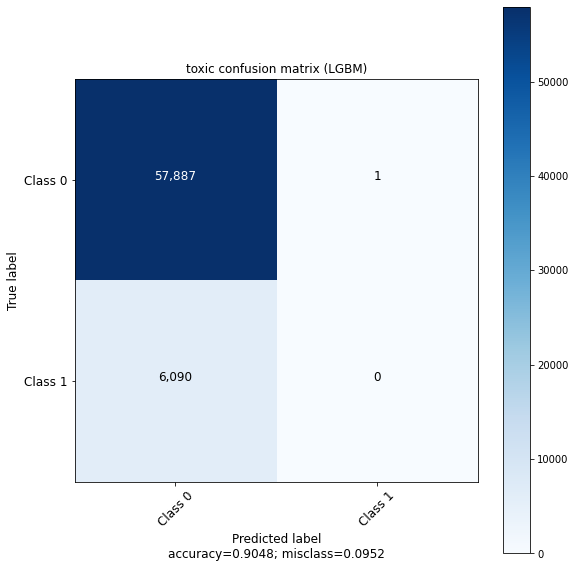

--------- severe_toxic Classification Report (LGBM) ---------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     63611
           1       0.13      0.21      0.16       367

    accuracy                           0.99     63978
   macro avg       0.56      0.60      0.58     63978
weighted avg       0.99      0.99      0.99     63978



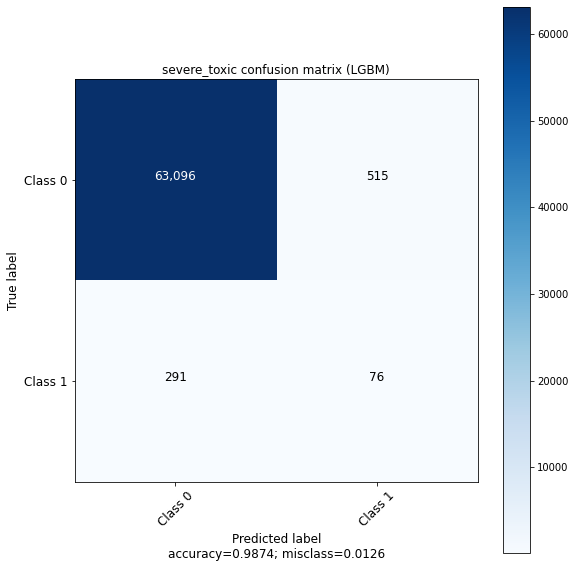

--------- obscene Classification Report (LGBM) ---------
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     60287
           1       0.11      0.36      0.16      3691

    accuracy                           0.79     63978
   macro avg       0.53      0.59      0.52     63978
weighted avg       0.91      0.79      0.84     63978



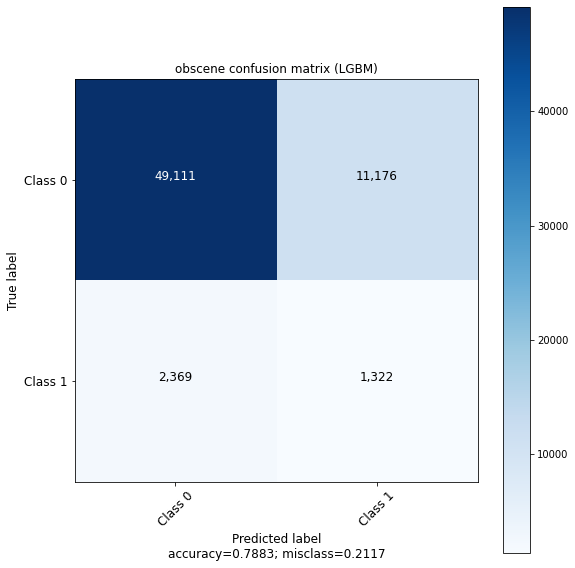

--------- threat Classification Report (LGBM) ---------
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     63767
           1       0.01      0.27      0.01       211

    accuracy                           0.84     63978
   macro avg       0.50      0.56      0.46     63978
weighted avg       0.99      0.84      0.91     63978



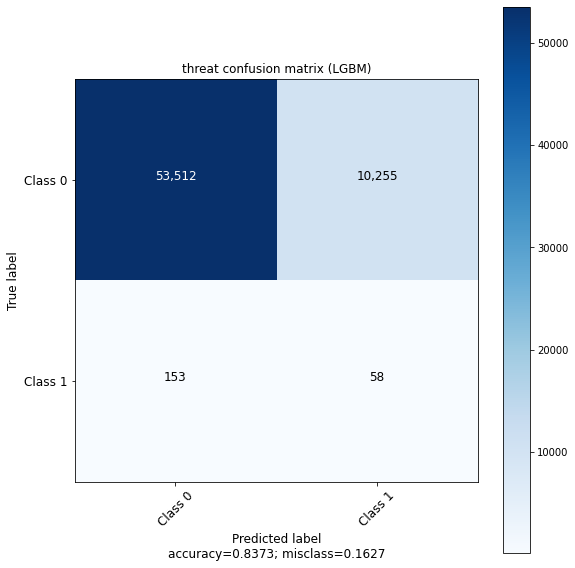

--------- insult Classification Report (LGBM) ---------
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     60551
           1       0.11      0.43      0.17      3427

    accuracy                           0.78     63978
   macro avg       0.54      0.62      0.52     63978
weighted avg       0.92      0.78      0.84     63978



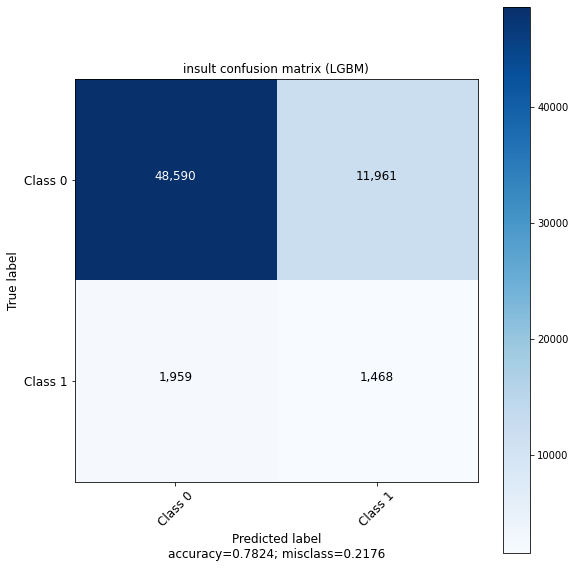

--------- identity_hate Classification Report (LGBM) ---------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     63266
           1       0.00      0.00      0.00       712

    accuracy                           0.99     63978
   macro avg       0.49      0.50      0.50     63978
weighted avg       0.98      0.99      0.98     63978



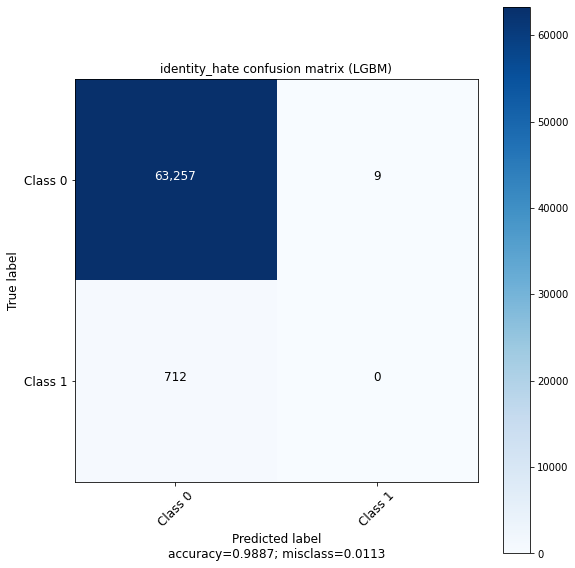

In [ ]:
######### PREDICT LABELS FOR TEST CLASS USING LIGHT GBM ########
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Make predictions using LGB model
for resp in class_names:
  training_labels = train[resp]
  test_labels = test[resp]
  seed = 1234
  # Create lgb datasets
  train_set = lgb.Dataset(train_features, label=training_labels, free_raw_data=False)
  test_set = lgb.Dataset(test_features, label=test_labels, free_raw_data=False)
  # Fit model
  model = lgb.train(params=lgb_params,
                      train_set=train_set, 
                      num_boost_round=500,
                      valid_sets=[test_set],
                      early_stopping_rounds=50,
                      verbose_eval=0)
  # Make predictions
  pred_probs = model.predict(test_features, num_iteration=model.best_iteration)
  # Find optimal decision threshold
  prec, recal, thresh = precision_recall_curve(test_labels, pred_probs)
  fscore = (2 * prec * recal) / (prec + recal)
  ix = np.argmax(fscore)
  preds=(pred_probs>= thresh[ix]).astype(int)
  print("--------- {} Classification Report (LGBM) ---------".format(resp))
  print(classification_report(test_labels, preds))
  # Plot confusion matrix
  plot_confusion_matrix(cm=confusion_matrix(test_labels, preds), target_names=["Class 0","Class 1"],
                        title='{} confusion matrix (LGBM)'.format(resp),
                        normalize=False,fontsize=12)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


--------- toxic Classification Report (NB-SVM) ---------
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     57888
           1       0.16      0.40      0.23      6090

    accuracy                           0.74     63978
   macro avg       0.54      0.59      0.54     63978
weighted avg       0.85      0.74      0.79     63978



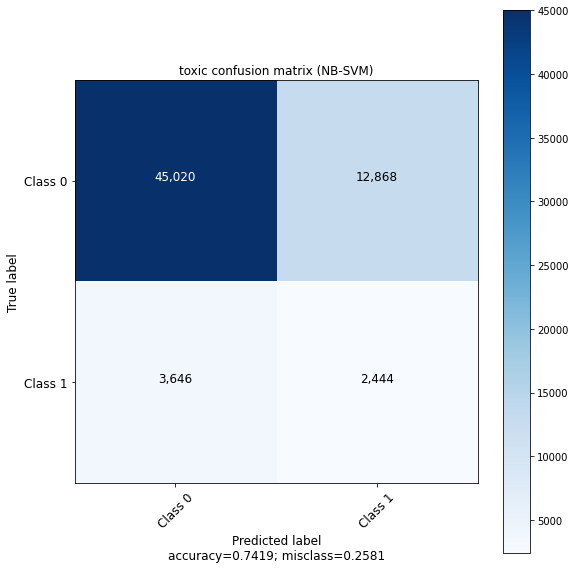

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


--------- severe_toxic Classification Report (NB-SVM) ---------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63611
           1       0.00      0.00      0.00       367

    accuracy                           0.99     63978
   macro avg       0.50      0.50      0.50     63978
weighted avg       0.99      0.99      0.99     63978



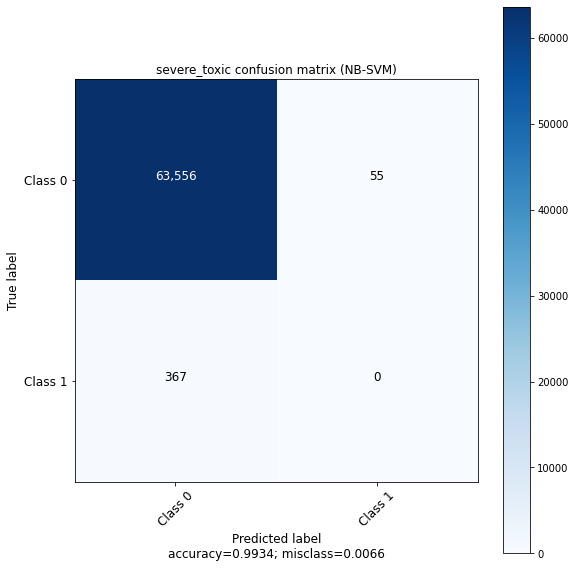

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


--------- obscene Classification Report (NB-SVM) ---------
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     60287
           1       0.19      0.25      0.22      3691

    accuracy                           0.90     63978
   macro avg       0.57      0.59      0.58     63978
weighted avg       0.91      0.90      0.90     63978



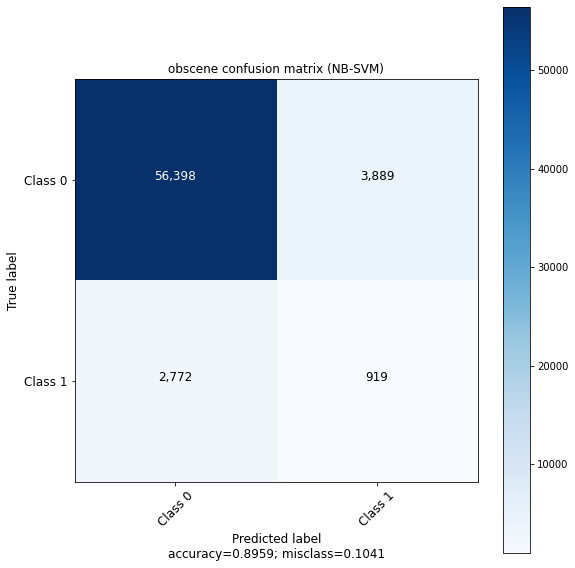

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


--------- threat Classification Report (NB-SVM) ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.00      0.00      0.00       211

    accuracy                           1.00     63978
   macro avg       0.50      0.50      0.50     63978
weighted avg       0.99      1.00      0.99     63978



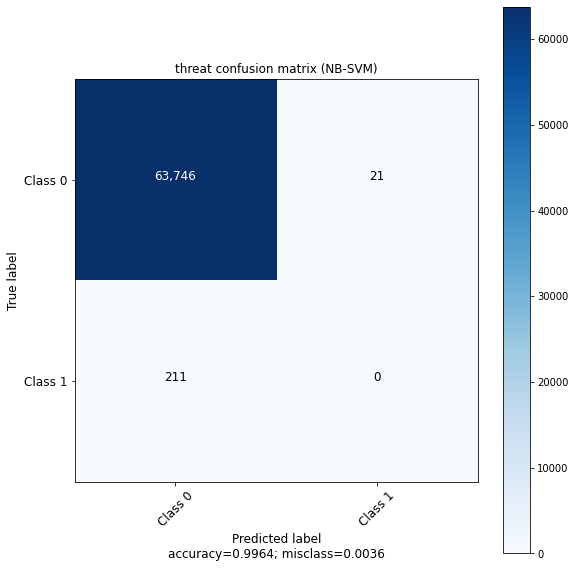

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


--------- insult Classification Report (NB-SVM) ---------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     60551
           1       0.00      0.00      0.00      3427

    accuracy                           0.95     63978
   macro avg       0.47      0.50      0.49     63978
weighted avg       0.90      0.95      0.92     63978



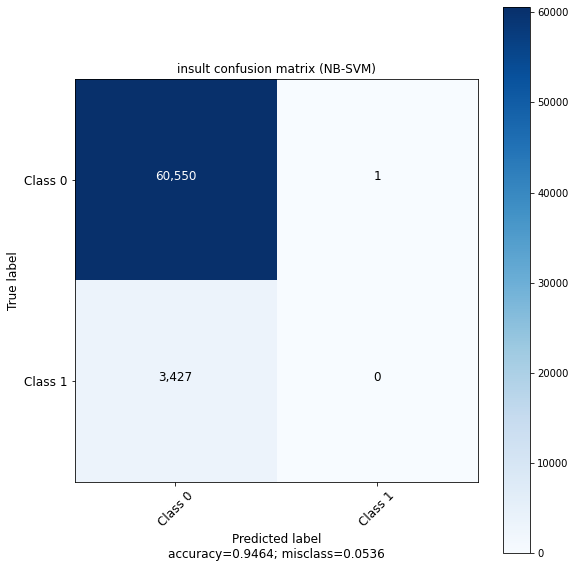

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


--------- identity_hate Classification Report (NB-SVM) ---------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     63266
           1       0.00      0.00      0.00       712

    accuracy                           0.99     63978
   macro avg       0.49      0.50      0.50     63978
weighted avg       0.98      0.99      0.98     63978



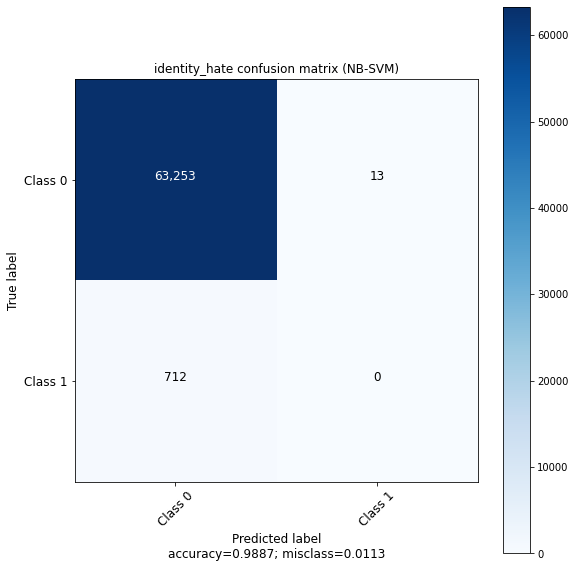

In [ ]:
######### PREDICT LABELS FOR TEST CLASS USING NB-SVM ########
text_col = 'clean_comments'
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
word_dict = {'toxic':10000,'severe_toxic':20000,'obscene':10000,'threat':15000,'insult':10000,'identity_hate':30000}
char_dict = {'toxic':20000,'severe_toxic':25000,'obscene':25000,'threat':15000, 'insult':40000, 'identity_hate':15000}

for resp in class_names:
  training_labels = train[resp]
  test_labels = test[resp]
  seed = 1234
  # Instantiate TfidfVecotrizers for features
  word_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    tokenizer=tokenize,
    #min_df = 3,
    max_df = 0.9,
    strip_accents='unicode',
    analyzer='word',
    stop_words='english',
    use_idf=True,
    sublinear_tf=True,
    smooth_idf=True,
    max_features=word_dict[resp])
  char_vectorizer = TfidfVectorizer(
      ngram_range=(2, 6),
      #min_df = 3,
      max_df = 0.9,
      strip_accents='unicode',
      analyzer='char',
      stop_words='english',
      use_idf=True,
      sublinear_tf=True,
      smooth_idf=True,
      max_features=char_dict[resp])
  # Train TfidfVectorizers, create features
  train_word = word_vectorizer.fit_transform(train[text_col])
  train_char = char_vectorizer.fit_transform(train[text_col])
  test_word = word_vectorizer.fit_transform(test[text_col])
  test_char = char_vectorizer.fit_transform(test[text_col])
  train_feats = hstack([train_word,train_char]).tocsr()
  test_feats = hstack([test_word,test_char]).tocsr()
  # Train + Fit model
  model = NbSvmClassifier(C=4, tol=1e-4, dual=True, n_jobs=-1,multi_class='auto',class_weight='balanced',solver='liblinear',max_iter=1000)
  model.fit(train_feats, training_labels)
  # Make predictions
  pred_probs = model.predict_proba(test_feats)[:,1]
  # Find optimal decision threshold
  prec, recal, thresh = precision_recall_curve(test_labels, pred_probs)
  fscore = (2 * prec * recal) / (prec + recal)
  ix = np.argmax(fscore)
  preds=(pred_probs >= thresh[ix]).astype(int)
  print("--------- {} Classification Report (NB-SVM) ---------".format(resp))
  print(classification_report(test_labels, preds))
  # Plot confusion matrix
  plot_confusion_matrix(cm=confusion_matrix(test_labels, preds), target_names=["Class 0","Class 1"],
                        title='{} confusion matrix (NB-SVM)'.format(resp),
                        normalize=False,fontsize=12)


In [6]:
# Split test set in half to make predictions for insult class
resp = 'insult'

div = test.shape[0]//3

first_test = test.iloc[:div,]
second_test = test.iloc[div:div*2,]
third_test = test.iloc[div*2:,]

first_test_feats = test_features[np.arange(div),:]
second_test_feats = test_features[np.arange(div,div*2),:]
third_test_feats = test_features[np.arange(div*2,test.shape[0]),:]

In [ ]:
######### FINAL SUBMISSION ENSEMBLING LGBM + NB-SVM ########
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
text_col = 'clean_comments'
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
word_dict = {'toxic':10000,'severe_toxic':20000,'obscene':10000,'threat':15000,'insult':10000,'identity_hate':30000}
char_dict = {'toxic':20000,'severe_toxic':25000,'obscene':25000,'threat':15000, 'insult':40000, 'identity_hate':15000}
best_algos = {'toxic':'LGBM','severe_toxic':'LGBM','obscene':'NBSVM','threat':'NBSVM','insult':'NBSVM','identity_hate':'LGBM'}
#output_preds = {}

# For every class, use best-performing algorithm to make predictions
# Due to memory limits, predict one class at a time
#for resp in class_names:
resp = class_names[4]
training_labels = train[resp]
#test_labels = test[resp]
test_labels = second_test[resp]
seed = 1234
if best_algos[resp] == 'LGBM':
  # Create lgb datasets
  train_set = lgb.Dataset(train_features, label=training_labels, free_raw_data=False)
  #test_set = lgb.Dataset(test_features, label=test_labels, free_raw_data=False)
  test_set = lgb.Dataset(second_test_feats, label=test_labels, free_raw_data=False)
  # Fit model
  model = lgb.train(params=lgb_params,
                      train_set=train_set, 
                      num_boost_round=500,
                      valid_sets=[test_set],
                      early_stopping_rounds=50,
                      verbose_eval=0)
  # Make predictions
  #pred_probs = model.predict(test_features, num_iteration=model.best_iteration)
  pred_probs = model.predict(second_test_feats, num_iteration=model.best_iteration)
  output_preds = pd.concat([second_test['id'],pd.DataFrame(pred_probs,columns=[resp])],axis=1)
else:
  # Instantiate TfidfVecotrizers for features
  word_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    tokenizer=tokenize,
    #min_df = 3,
    max_df = 0.9,
    strip_accents='unicode',
    analyzer='word',
    stop_words='english',
    use_idf=True,
    sublinear_tf=True,
    smooth_idf=True,
    max_features=word_dict[resp])
  char_vectorizer = TfidfVectorizer(
      ngram_range=(2, 6),
      #min_df = 3,
      max_df = 0.9,
      strip_accents='unicode',
      analyzer='char',
      stop_words='english',
      use_idf=True,
      sublinear_tf=True,
      smooth_idf=True,
      max_features=char_dict[resp])
  # Train TfidfVectorizers, create features
  train_word = word_vectorizer.fit_transform(train[text_col])
  train_char = char_vectorizer.fit_transform(train[text_col])
  test_word = word_vectorizer.fit_transform(second_test[text_col])
  test_char = char_vectorizer.fit_transform(second_test[text_col])
  train_feats = hstack([train_word,train_char]).tocsr()
  test_feats = hstack([test_word,test_char]).tocsr()
  # Train + Fit model
  model = NbSvmClassifier(C=4, tol=1e-4, dual=True, n_jobs=-1,multi_class='auto',class_weight='balanced',solver='liblinear',max_iter=1000)
  model.fit(train_feats, training_labels)
  # Make predictions
  pred_probs = model.predict_proba(test_feats)[:,1]
  output_preds = pd.concat([second_test['id'],pd.DataFrame(pred_probs,columns=[resp])],axis=1)
print("Predictions for class {} have been created.".format(resp))

In [8]:
# Merge all prediction dataframes together
#final_df = test['id']
#for resp in output_preds.keys():
#  final_df = final_df.merge(output_preds[resp],on='id')
final_df = output_preds

# Save final submission file
final_df.to_csv("final_predictions_{}_p2.csv".format(resp),index=False)